# part5
## Full Implementation of the paper


### The next is Basic Function and Process Block

In [19]:
## this is the origin Fundamental Matrix
import numpy
import cv2
from gco import pygco
import matplotlib.pyplot as plt
import os
import typing
import math
import functools

ROAD_FILE_PATH = "Road"
ROAD_FRAME_PATH = f"{ROAD_FILE_PATH}{os.sep}src"
CAMERAS_PARAMETERS_PATH = f"{ROAD_FILE_PATH}{os.sep}cameras.txt"
file_list: typing.List[str] = os.listdir(path=ROAD_FRAME_PATH)
file_list.sort()
print(f"file_list:{file_list}")
frame_num: int = len(file_list)
camera_paramters:numpy.mat = \
    numpy.mat(data=numpy.loadtxt(fname=CAMERAS_PARAMETERS_PATH, 
                                 dtype=numpy.float32, skiprows=1),
              dtype=numpy.float32)
K = []
R = []
T = []
for i in range(frame_num):
    K.append(camera_paramters[7*i:7*i+3, :])
    R.append(camera_paramters[7*i+3:7*i+6, :])
    T.append(camera_paramters[7*i+6, :])
print(f"k:{len(K)} file_list:{len(file_list)}")
camera_paramters = None
print(f"road {ROAD_FRAME_PATH}{os.sep}{file_list[0]}")
img0: numpy.ndarray = cv2.imread(f"{ROAD_FRAME_PATH}{os.sep}{file_list[0]}", cv2.IMREAD_COLOR)
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
# img2 = cv2.resize(img2, (width1, height1))
BASE_HEIGHT, BASE_WIDTH, _ = img0.shape

# @cache
def compute_distance(point1: numpy.ndarray, point2: numpy.ndarray) -> float:
    """
    compute distance of two pixels
    Parameters
    ----------
    point1: ndarray, uint8, shape=(3)
        point one
    point2: ndarray, uint8, shape=(3)
        point two
    """
    # return (abs(point1[0]-point2[0]) + abs(point1[1] - point2[1]) + abs(point1[2] - point2[2]) ) / 3 / 255
    # if not dividing 255 as the C pseudocode example, there will be a overflowing of MAX_VALUE of Integer when calling pycgo.cut_grid_graph
    return numpy.sum(numpy.abs(point1-point2)) /3 / 255
# NUM_FRAMES_PROCESSED: int = 2
NUM_FRAMES_PROCESSED: int = 10
# 0-1
SIGMA_C = 1
SIGMA_D = 2.5
SIGMAD_D_2 = 2 * (SIGMA_D**2)
STEP = 59
D_MAX = 0.02
DISPARITY_RANGE: float = D_MAX / STEP

WS = 1
EPSILON_LAMBDA = 0.001
EPSILON_MU = 0.001
MAX_DIFF = 1
LAMBDA = 0.05
LAMBDA_BUNDLE = 0.1
# @functools.cache
def compute_pc(difference: float) -> float:
    """
        Args:
            disparity: |It(x) - It'(ltt'(x,d))| >=0
    """
    return SIGMA_C / (SIGMA_C + difference)

# @functools.cache
def compute_pv(distance:int)-> float:
    return math.exp((-(distance))/SIGMAD_D_2)

# @functools.cache
def get_paramters(origin_idx: int, target_idx: int)-> typing.Tuple[numpy.mat, numpy.mat]:
    tem_k1 = K[origin_idx]
    tem_r1 = R[origin_idx]
    tem_t1 = T[origin_idx]
    tem_k2 = K[target_idx]
    tem_r2 = R[target_idx]
    tem_t2 = T[target_idx]
    tem_point_part_matrice = tem_k2 @ tem_r2.T @ tem_r1 @ numpy.linalg.inv(tem_k1)
    tem_epipolar_line_matrice = tem_k2 @ tem_r2.T @ numpy.mat(tem_t1-tem_t2).T
    return tem_point_part_matrice, tem_epipolar_line_matrice

# @functools.cache
def get_epipolar_line(origin_idx: int, target_idx: int, d: float)->numpy.ndarray:
    _, tem_epipolar_line_matrice = get_paramters(origin_idx=origin_idx, target_idx=target_idx)
    epipolar_line = d * tem_epipolar_line_matrice
    return epipolar_line

# @functools.cache
def compute_mu(difference: float) -> float:

    pass

def _compute_distance(img1:numpy.ndarray, img2: numpy.ndarray) -> numpy.ndarray:
    # return numpy.sum(numpy.abs(img_a - img_b), axis=-1, keepdims=True)
    return numpy.sqrt(numpy.sum(numpy.square(img1-img2), axis=-1, keepdims=True))


def _generate_fp(step:int,threshold:int):
    fp = numpy.zeros(shape=(step,step), dtype=numpy.int32)
    for i in range(step):
        for j in range(step):
            if i!= j:
                fp[i][j] = min(abs(i-j),threshold)
    return fp

def _get_img_color(img: numpy.ndarray, position: numpy.ndarray):
    # position = numpy.transpose(position[:2,:,:], [1,2,0])
    return cv2.remap(src=img, map1=numpy.float32(position), map2=None, interpolation=cv2.INTER_NEAREST, borderValue=[128, 128, 128])

def compute(start_frame_num: int, is_output_result: bool = True) -> typing.Tuple[typing.List[numpy.ndarray], typing.List[numpy.ndarray], typing.List[numpy.ndarray]]:
    pc_list: typing.List[numpy.ndarray] = []
    labels_list: typing.List[numpy.ndarray] = []
    start = start_frame_num
    end = start + (NUM_FRAMES_PROCESSED - 1)
    # tem_k: typing.List[numpy.mat] = K[start:end+1]
    # tem_r: typing.List[numpy.mat] = R[start:end+1]
    # tem_t: typing.List[numpy.mat] = T[start:end+1]
    K1 = K[start]
    R1 = R[start]
    T1 = T[start].T
    K1_inv: numpy.mat =  numpy.mat(data=numpy.linalg.inv(K1))
    img_list= [None] * NUM_FRAMES_PROCESSED
    L = None
    D= None
    for i in range(NUM_FRAMES_PROCESSED):
        idx = i + start
        img: numpy.ndarray = cv2.imread(f"{ROAD_FRAME_PATH}{os.sep}{file_list[idx]}", cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = cv2.resize(src=img, dsize=(BASE_WIDTH, BASE_HEIGHT))
        img_list[i] = img
    img0: numpy.ndarray = img_list[0]
    height0, width0, _ = img0.shape
    L = numpy.zeros([STEP, height0, width0], dtype=numpy.float32)
    num = 0
    num_images_per_row = 3
    plt.figure(figsize=(15, 10))  # 调整图像大小

    for i in range(1, NUM_FRAMES_PROCESSED):
        idx = start + i
        K2 = K[idx]
        R2 = R[idx]
        T2 = T[idx].T
        X,Y = numpy.int32(numpy.meshgrid(numpy.arange(width0, dtype=numpy.int32),
                                         numpy.arange(height0, dtype=numpy.int32)))
        X, Y, Z = (numpy.expand_dims(a=X, axis=0), numpy.expand_dims(a=Y, axis=0), numpy.ones(shape=(1, height0, width0), dtype=numpy.int32))
        homo_coordinates: numpy.ndarray = numpy.concatenate((X, Y, Z), axis=0)
        for s in range(STEP):
            d = s * DISPARITY_RANGE
            d_arr = numpy.full(shape=(1, height0 *width0), fill_value=d, dtype=numpy.float32)
            coorsxy = numpy.reshape(homo_coordinates, [3,-1])
            depth = (T1-T2) @ d_arr
            projected_pos = (K1*R2.T) * ((R1*K1_inv) * coorsxy + depth)
            projected_pos = numpy.divide(projected_pos, projected_pos[2, :])
            projected_pos = numpy.reshape(numpy.asarray(projected_pos), [3, height0, width0])
            projected_pos = numpy.transpose(projected_pos[:2,:,:], [1,2,0])

            color_img2 = _get_img_color(img=img_list[i] , position=projected_pos)
            color_distance = _compute_distance(color_img2, img0)
            pc = SIGMA_C/(SIGMA_C + color_distance)
            pc_list.append(pc)
            L[s,:,:] += pc[:,:,0]
        u = numpy.reciprocal(L.max(axis=0, keepdims=True))    
        unary= 1 - u * L
        confine_unary=numpy.zeros((height0, width0, STEP))
        for s in range(STEP):
            confine_unary[:,:,s] = unary[s,:,:]
        fp = _generate_fp(step=STEP, threshold=10)
        # print(f"basic confine_unary:{confine_unary}")
        labels = pygco.cut_grid_graph_simple(confine_unary, fp*LAMBDA, connect=8, n_iter=-1)
        labels = labels.reshape(height0, width0)
        labels_list.append(labels)
        # D[i,:,:] = labels
        if is_output_result:
            if num < num_images_per_row:
                plt.subplot(1, num_images_per_row, num + 1)
                plt.imshow(labels, cmap='gray')
                plt.title(f'initial Frame {idx}')
                plt.axis('off')
                num += 1
            else:
                # 显示当前行，并开始新的一行
                plt.show()
                plt.figure(figsize=(15, 10))  # 调整图像大小
                plt.subplot(1, num_images_per_row, 1)
                plt.imshow(labels, cmap='gray')
                plt.title(f'initial Frame {idx}')
                plt.axis('off')
                num = 1  # 重置计数器并包含当前图像
    if is_output_result and num > 0:
        plt.show()
    return pc_list, labels_list, img_list

# init_depth_map_list: typing.List[numpy.ndarray] = compute(start_frame_num=0)
def compute_with_bundle_optimize(start_frame_num:int) -> None:
    # index 0 -> there is no depth map
    # pc_list,labels_list, img_list = compute(start_frame_num=0, is_output_result=False)
    pc_list,labels_list, img_list = compute(start_frame_num=start_frame_num, is_output_result=True)
    pc_list.insert(0, None)
    labels_list.insert(0, None)
    # print(f"pc_list.len:{len(pc_list)}")
    # print(f"img_list.len:{len(img_list)}")
    # print(f'pc_list:{pc_list}')
    start = start_frame_num
    K1 = K[start]
    R1 = R[start]
    T1 = T[start].T
    K1_inv: numpy.mat =  numpy.mat(data=numpy.linalg.inv(K1))
    img0: numpy.ndarray = img_list[0]
    height0, width0, _ = img0.shape
    X,Y = numpy.int32(numpy.meshgrid(numpy.arange(width0, dtype=numpy.int32),
                                     numpy.arange(height0, dtype=numpy.int32)))
    X, Y, Z = (numpy.expand_dims(a=X, axis=0), numpy.expand_dims(a=Y, axis=0), numpy.ones(shape=(1, height0, width0), dtype=numpy.int32))
    L = numpy.zeros((STEP, height0, width0), dtype=numpy.float32) #[d_numbers, h, w]
    plt.figure(figsize=(100, 80))  # 调整图像大小
    num = 0
    num_images_per_row = 5
    num_rows = (NUM_FRAMES_PROCESSED + num_images_per_row - 1) // num_images_per_row
    for i in range(1, NUM_FRAMES_PROCESSED):
        num +=1
        idx = start + i
        K2 = K[idx]
        R2 = R[idx]
        T2 = T[idx].T
        K2_inv: numpy.mat =  numpy.mat(data=numpy.linalg.inv(K2))
        plt.figure(figsize=(100, 80))  # 调整图像大小

        for s in range(STEP):
            d = s * DISPARITY_RANGE
            d_arr = numpy.full(shape=(1, height0 *width0), fill_value=d, dtype=numpy.float32)
            d_arr = numpy.matrix(data=d_arr)
            homo_coordinates: numpy.ndarray = numpy.concatenate((X, Y, Z), axis=0)
            coorsxy = numpy.reshape(homo_coordinates, [3,-1])
            coorsxy = numpy.matrix(data=coorsxy)
            depth = (T1-T2) @ d_arr
            remap = (K2*R2.T) @ ((R1@K1_inv) @ coorsxy + depth)
            remap = numpy.divide(remap, remap[2, :])
            remap = numpy.reshape(numpy.asarray(remap), [3, height0, width0])
            projected_pos = numpy.transpose(remap[:2,:,:], [1,2,0])
            color_img2 = _get_img_color(img=img_list[i], position=projected_pos)
            color_distance = _compute_distance(img1=color_img2, img2=img0)
            pc = SIGMA_C / (SIGMA_C + color_distance)
            origin_labels = labels_list[i]
            label_projected = _get_img_color(img=origin_labels, position=projected_pos)
            disparity_projected = label_projected * DISPARITY_RANGE
            new_d_arr = numpy.reshape(disparity_projected, (1,-1))

            coorsxy_inv = remap
            coorsxy_inv = numpy.reshape(coorsxy_inv, [3,-1])
            depth = (T2-T1) @ new_d_arr
            print(f"coorsxy_inv:{coorsxy_inv.shape}")
            coorsxy_inv = numpy.matrix(data=coorsxy_inv)
            tem = (K1@R1.T) @ ((R2*K2_inv) @ coorsxy_inv + depth)
            tem = numpy.divide(tem, tem[2, :])
            tem = numpy.reshape(numpy.asarray(tem), [3, height0, width0])
            tem = tem.transpose(1, 2, 0)
            homo_coordinates = homo_coordinates.transpose(1, 2, 0)
            print(f"homo_coordinates:{homo_coordinates.shape}")
            print(f"tem:{tem.shape}")
            coor_dist = _compute_distance(img1=homo_coordinates,img2=tem)
            pv = numpy.exp(coor_dist/(-SIGMAD_D_2))
            print(f"pc:{pc.shape}, pv:{pv.shape}")
            L[s,:,:] += (pc*pv)[:,:,0]
    u = numpy.reciprocal(L.max(axis=0, keepdims=True))
    unary= 1 - u*L
    confine_unary=numpy.zeros((height0, width0, STEP))
    cur_count_confie = 1
    for s in range(STEP):
        confine_unary[:,:,s] = unary[s,:,:]
    for level1 in range(confine_unary.shape[0]):
        for level2 in range(confine_unary.shape[1]):
            cur_count_confie += 1
            if cur_count_confie > 100:
                break
            print(confine_unary[level1, level2])
    fp = _generate_fp(step=STEP, threshold=10)
    confine_unary = numpy.log(confine_unary)
    labels = pygco.cut_grid_graph_simple(confine_unary, fp*LAMBDA_BUNDLE, connect=8, n_iter=100000000)
    labels = labels.reshape(height0, width0)
    plt.imshow(labels, cmap='gray')
    plt.title(f'Bundle Resule from {start_frame_num} to {start_frame_num + NUM_FRAMES_PROCESSED - 1}')
    return labels, labels_list
# for start_frame in range(0, len(file_list), NUM_FRAMES_PROCESSED):
#     if start_frame + NUM_FRAMES_PROCESSED - 1 >= len(file_list):
#         start_frame =  len(file_list) - NUM_FRAMES_PROCESSED
#     compute_with_bundle_optimize(start_frame_num=start_frame)


file_list:['test0000.jpg', 'test0001.jpg', 'test0002.jpg', 'test0003.jpg', 'test0004.jpg', 'test0005.jpg', 'test0006.jpg', 'test0007.jpg', 'test0008.jpg', 'test0009.jpg', 'test0010.jpg', 'test0011.jpg', 'test0012.jpg', 'test0013.jpg', 'test0014.jpg', 'test0015.jpg', 'test0016.jpg', 'test0017.jpg', 'test0018.jpg', 'test0019.jpg', 'test0020.jpg', 'test0021.jpg', 'test0022.jpg', 'test0023.jpg', 'test0024.jpg', 'test0025.jpg', 'test0026.jpg', 'test0027.jpg', 'test0028.jpg', 'test0029.jpg', 'test0030.jpg', 'test0031.jpg', 'test0032.jpg', 'test0033.jpg', 'test0034.jpg', 'test0035.jpg', 'test0036.jpg', 'test0037.jpg', 'test0038.jpg', 'test0039.jpg', 'test0040.jpg', 'test0041.jpg', 'test0042.jpg', 'test0043.jpg', 'test0044.jpg', 'test0045.jpg', 'test0046.jpg', 'test0047.jpg', 'test0048.jpg', 'test0049.jpg', 'test0050.jpg', 'test0051.jpg', 'test0052.jpg', 'test0053.jpg', 'test0054.jpg', 'test0055.jpg', 'test0056.jpg', 'test0057.jpg', 'test0058.jpg', 'test0059.jpg', 'test0060.jpg', 'test0061.jpg

In [20]:
@functools.cache
def get_img(index: int) -> numpy.ndarray:
    tem_img: numpy.ndarray = cv2.imread(f"{ROAD_FRAME_PATH}{os.sep}{file_list[index]}", cv2.IMREAD_COLOR)
    tem_img = cv2.cvtColor(tem_img, cv2.COLOR_BGR2RGB)
    return tem_img

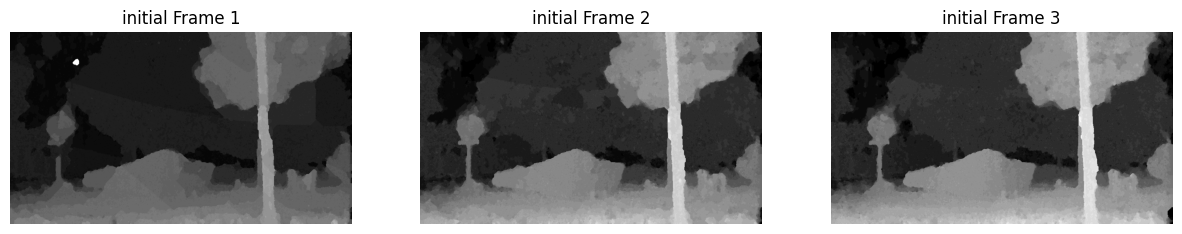

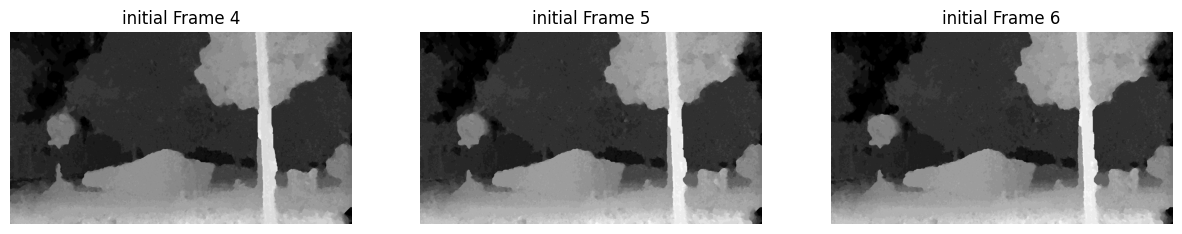

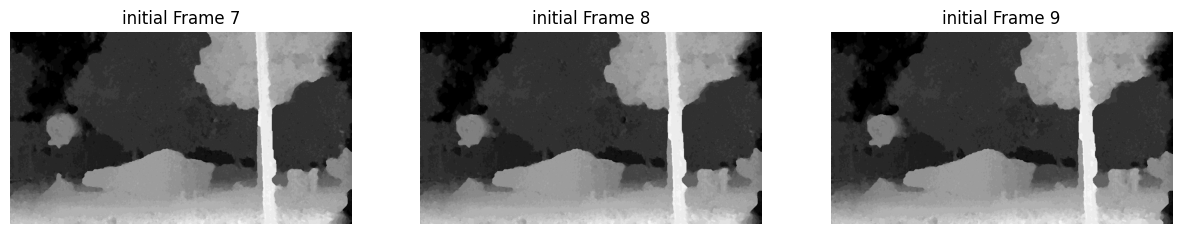

coorsxy_inv:(3, 518400)
homo_coordinates:(540, 960, 3)
tem:(540, 960, 3)
pc:(540, 960, 1), pv:(540, 960, 1)
coorsxy_inv:(3, 518400)
homo_coordinates:(540, 960, 3)
tem:(540, 960, 3)
pc:(540, 960, 1), pv:(540, 960, 1)
coorsxy_inv:(3, 518400)
homo_coordinates:(540, 960, 3)
tem:(540, 960, 3)
pc:(540, 960, 1), pv:(540, 960, 1)
coorsxy_inv:(3, 518400)
homo_coordinates:(540, 960, 3)
tem:(540, 960, 3)
pc:(540, 960, 1), pv:(540, 960, 1)
coorsxy_inv:(3, 518400)
homo_coordinates:(540, 960, 3)
tem:(540, 960, 3)
pc:(540, 960, 1), pv:(540, 960, 1)
coorsxy_inv:(3, 518400)
homo_coordinates:(540, 960, 3)
tem:(540, 960, 3)
pc:(540, 960, 1), pv:(540, 960, 1)
coorsxy_inv:(3, 518400)
homo_coordinates:(540, 960, 3)
tem:(540, 960, 3)
pc:(540, 960, 1), pv:(540, 960, 1)
coorsxy_inv:(3, 518400)
homo_coordinates:(540, 960, 3)
tem:(540, 960, 3)
pc:(540, 960, 1), pv:(540, 960, 1)
coorsxy_inv:(3, 518400)
homo_coordinates:(540, 960, 3)
tem:(540, 960, 3)
pc:(540, 960, 1), pv:(540, 960, 1)
coorsxy_inv:(3, 518400)
homo

/var/folders/f1/_b6gmc6s181cyttj1rzj61v40000gn/T/ipykernel_22868/3527795321.py:285: RuntimeWarning: divide by zero encountered in log
  confine_unary = numpy.log(confine_unary)
/Users/admin/EE5371/CA2/.venv/lib/python3.12/site-packages/gco/pygco.py:79: RuntimeWarning: invalid value encountered in cast
  return (e * _UNARY_FLOAT_PRECISION).astype(np.intc)


<Figure size 10000x8000 with 0 Axes>

<Figure size 10000x8000 with 0 Axes>

<Figure size 10000x8000 with 0 Axes>

<Figure size 10000x8000 with 0 Axes>

<Figure size 10000x8000 with 0 Axes>

<Figure size 10000x8000 with 0 Axes>

<Figure size 10000x8000 with 0 Axes>

<Figure size 10000x8000 with 0 Axes>

<Figure size 10000x8000 with 0 Axes>

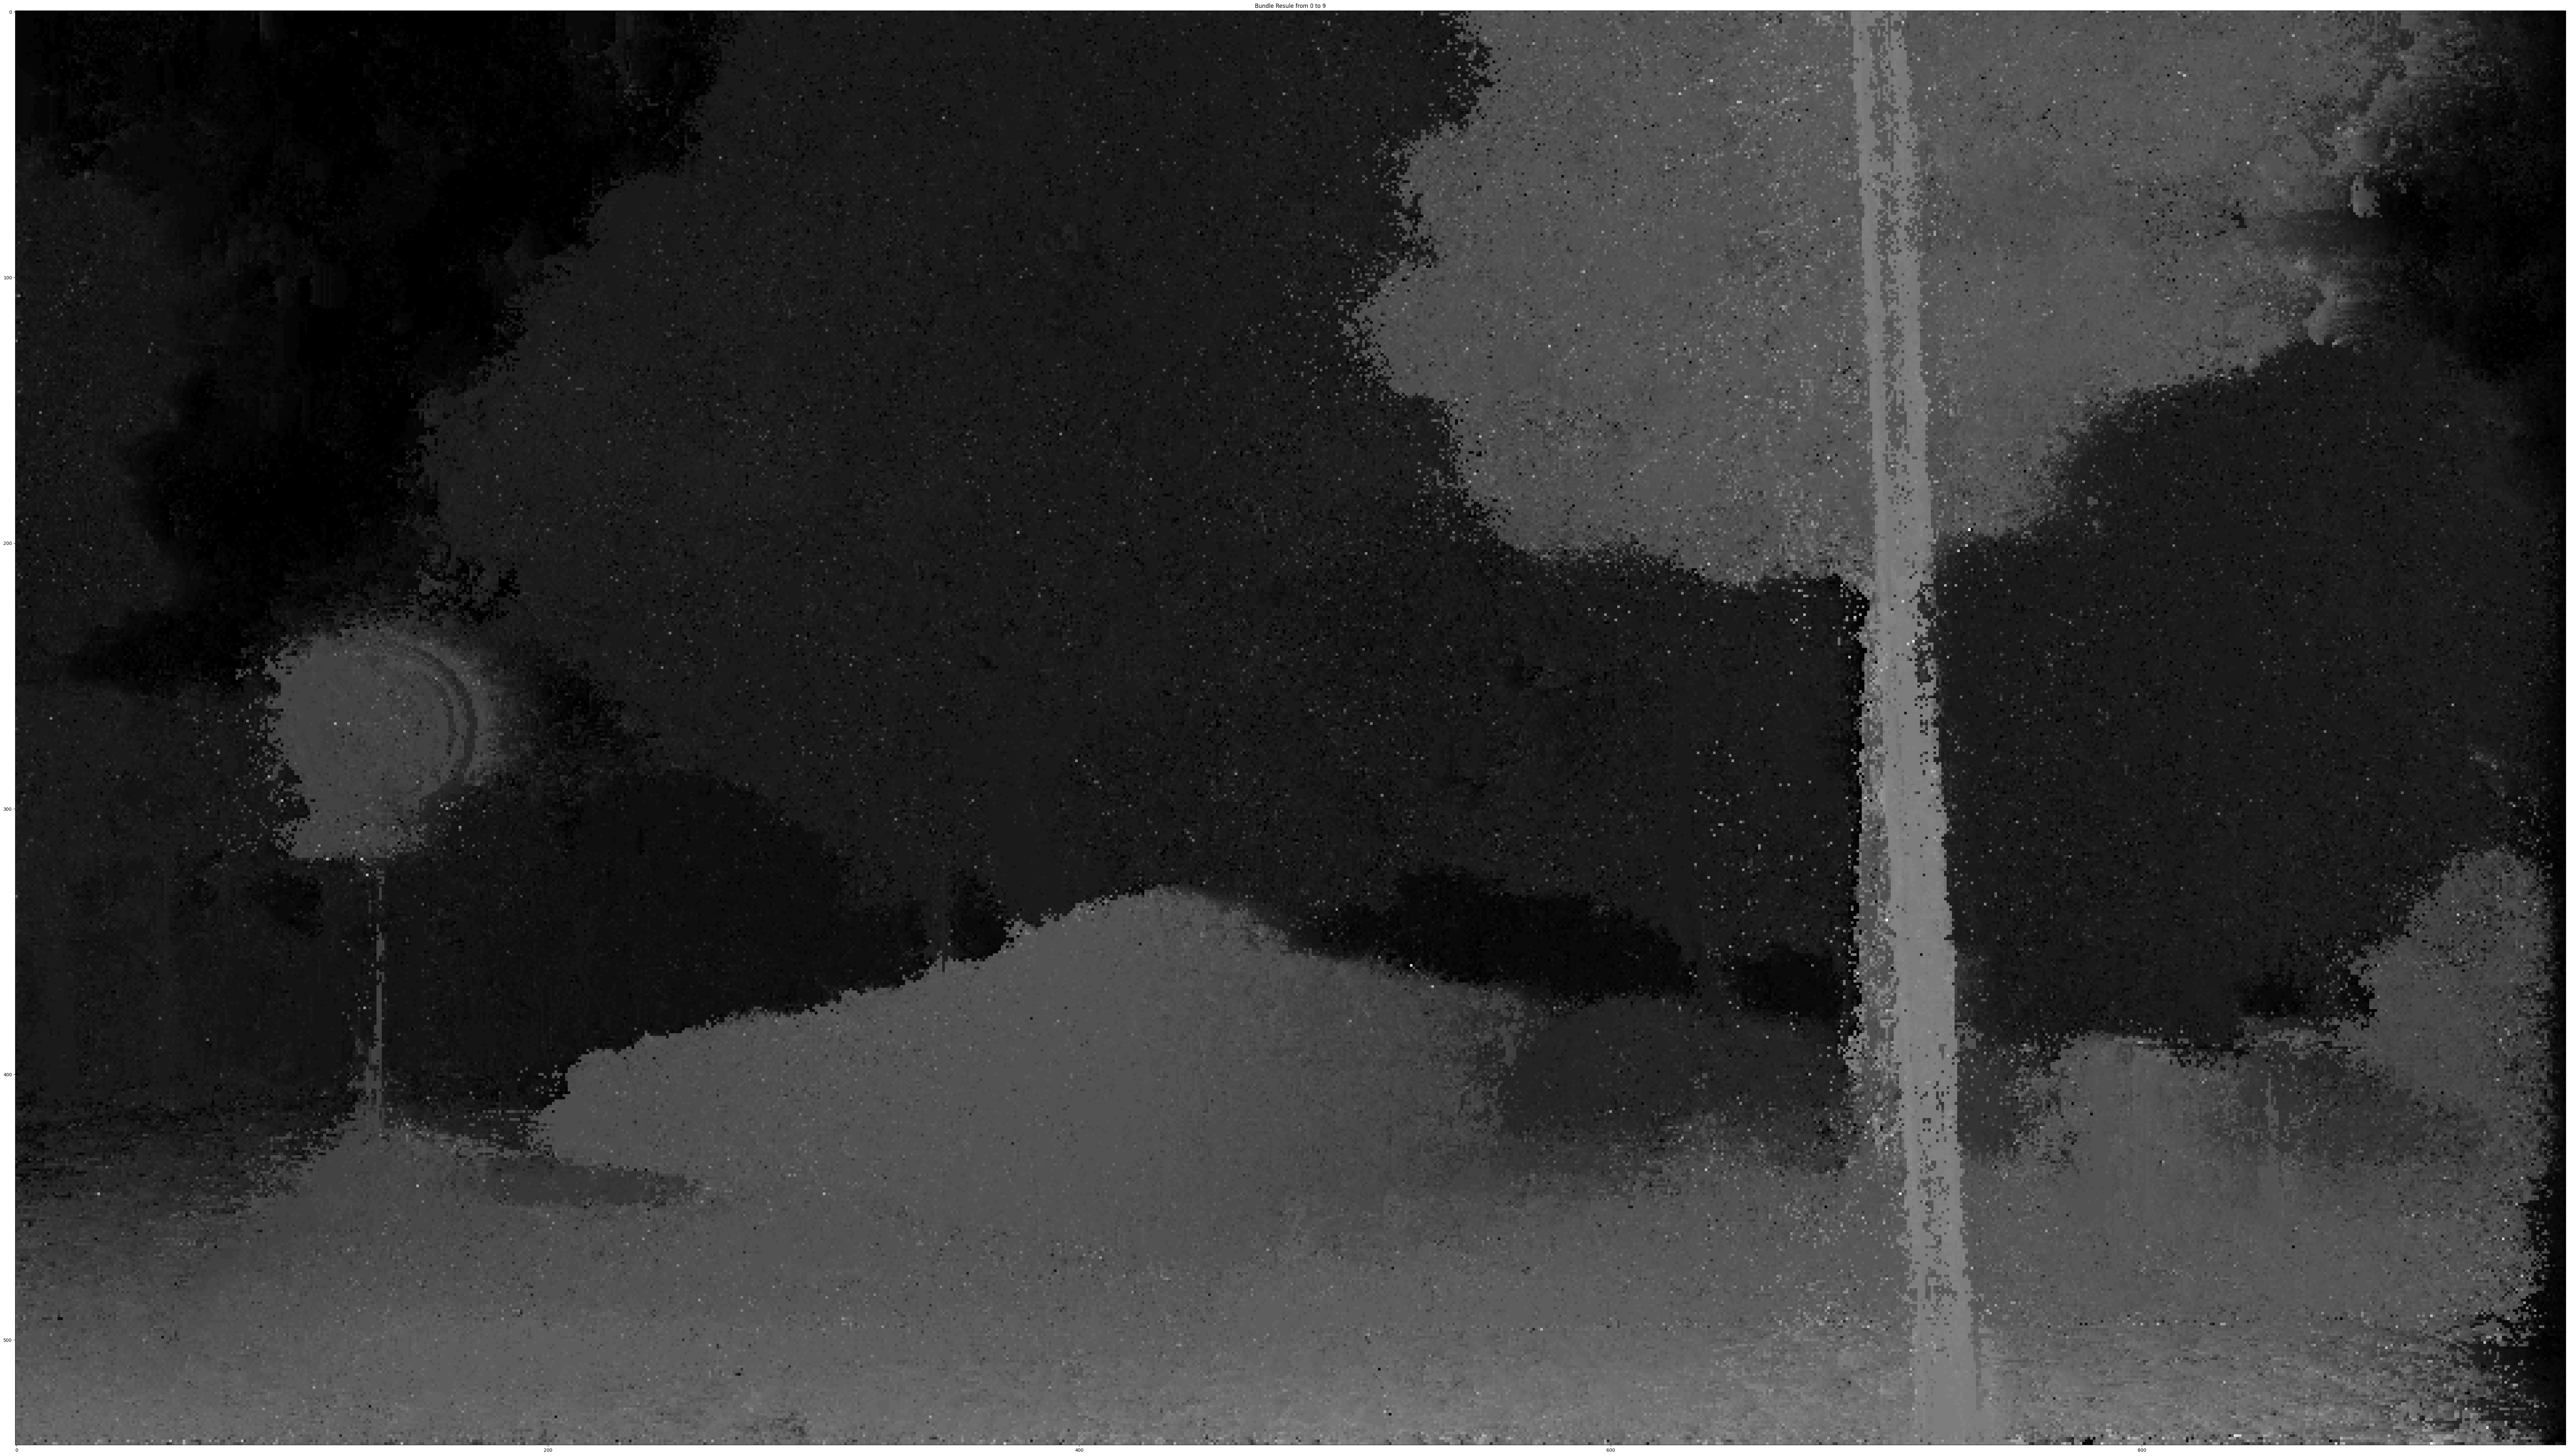

In [21]:
labels0, label_list0 =  compute_with_bundle_optimize(0)
# labels1, label_list1=  compute_with_bundle_optimize(10)


## Here is the implementation of part 2.2 Segmentation-Based Approaches in the paper.
# I used  Simple Linear Iterative Clustering methods
### the image titled with segmented depth XXX is the segmented result of initial depth  map
###  the image titled with segmented bundled depth is the segmented result of depth map after bundle Optimization


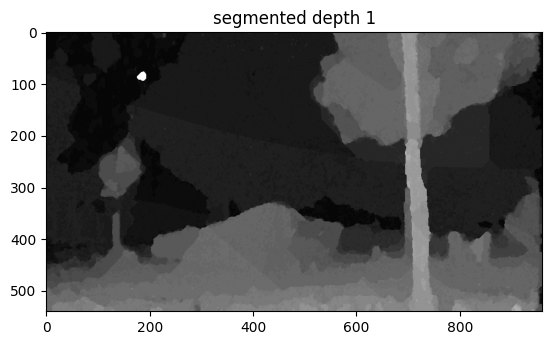

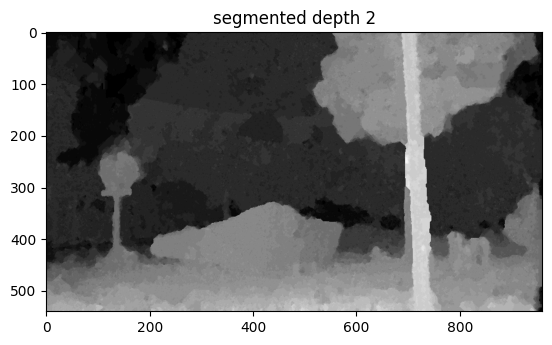

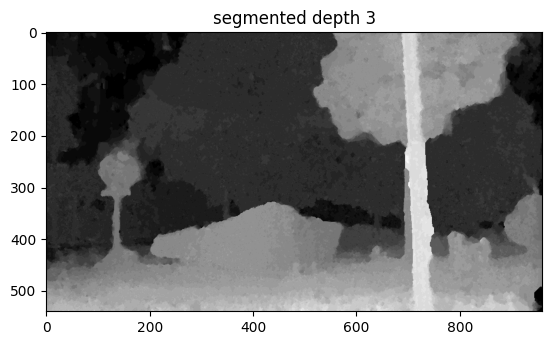

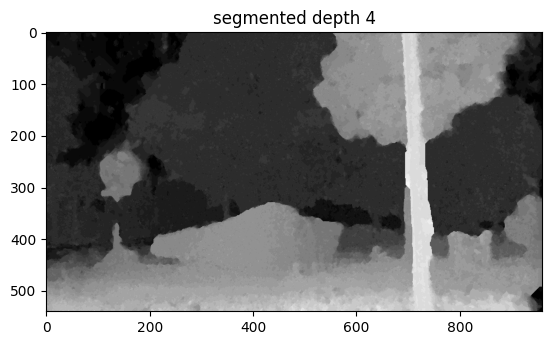

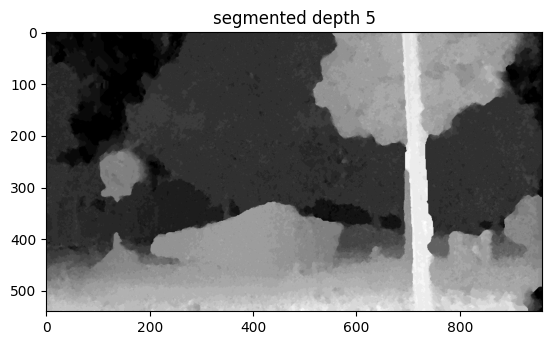

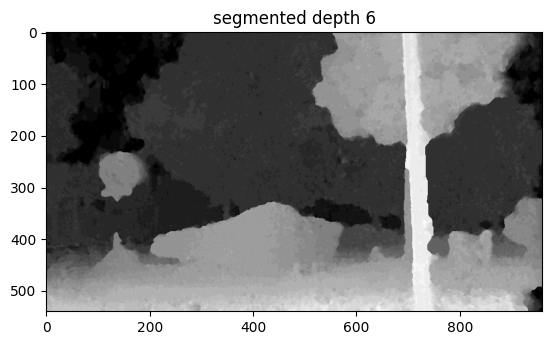

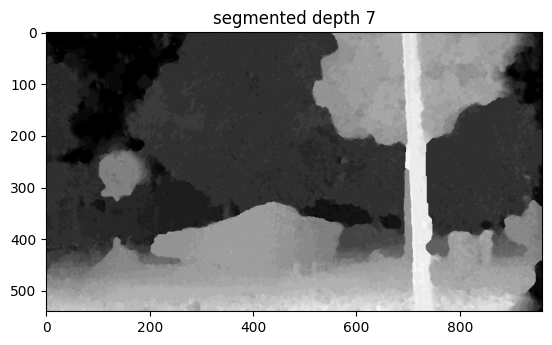

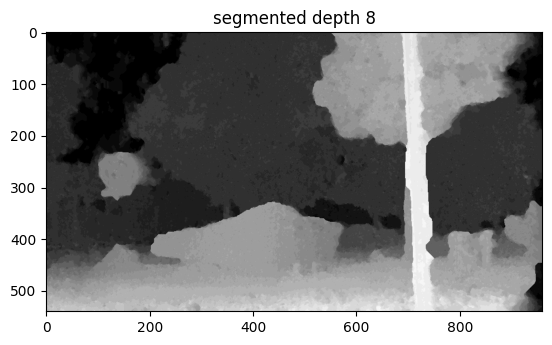

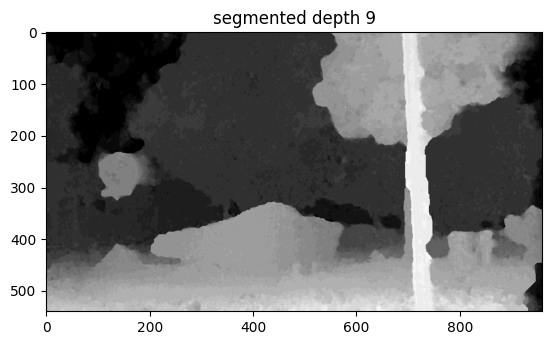

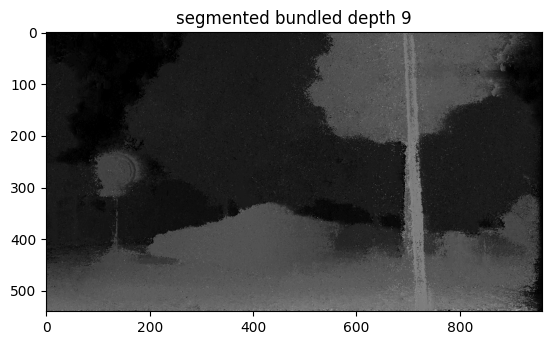

In [22]:
from skimage.segmentation import slic
from skimage.color import label2rgb


for i in range(1, len(label_list0)):
    img0 = get_img(0)
    cur_labels = label_list0[i]
    segments = slic(img0, n_segments=250, compactness=10, sigma=1)
    segmented_image = label2rgb(segments, img0, kind='avg')
    segment_depth = numpy.zeros_like(cur_labels)
    for (j, segment) in enumerate(numpy.unique(segments)):
        mask = numpy.zeros(img0.shape[:2], dtype="uint8")
        mask[segments == segment] = 255
        segment_depth = cv2.bitwise_and(src1=cur_labels, 
                                        src2=cur_labels, 
                                        dst=segment_depth, 
                                        mask=mask)
    plt.title(f'segmented depth {i}')
    plt.imshow(segment_depth, cmap='gray')
    plt.show()
img0 = get_img(0)
cur_labels = labels0
segments = slic(img0, n_segments=250, compactness=10, sigma=1)
segmented_image = label2rgb(segments, img0, kind='avg')
segment_depth = numpy.zeros_like(cur_labels)
for (j, segment) in enumerate(numpy.unique(segments)):
    mask = numpy.zeros(img0.shape[:2], dtype="uint8")
    mask[segments == segment] = 255
    segment_depth = cv2.bitwise_and(src1=cur_labels, 
                                    src2=cur_labels, 
                                    dst=segment_depth, 
                                    mask=mask)

plt.title(f'segmented bundled depth')
plt.imshow(segment_depth, cmap='gray')
plt.show()


# Problem1: Still with noise
## After Bundle Optimization, there are still noises in the sky and the pole
## apply spcae time fusion
# Not yet finished

In [ ]:



def space_time_fusion(points_sets, camera_params_sets):
    global_model = None
    
    for t, points in enumerate(points_sets):
        camera_params = camera_params_sets[t]
        
        processed_points = process_points_at_time_t(points, camera_params)
        
        global_model = fuse_into_global_model(global_model, processed_points)
    
    global_model_smoothed = apply_temporal_smoothing(global_model)
    
    return global_model_smoothed

def process_points_at_time_t(points, camera_params):

    return processed_points

def fuse_into_global_model(global_model, processed_points):

    return updated_global_model

def apply_temporal_smoothing(global_model):

    return smoothed_model

global_model = space_time_fusion([points_t1, points_t2, ...], [cam_params_t1, cam_params_t2, ...])





## Here is to implement 2.4 Multiview Stereo Methods for Reconstructing 3D Models in paper
# Not yet finished

In [23]:
from mpl_toolkits.mplot3d import Axes3D
sift = cv2.SIFT.create()
keypoints_all = []
descriptors_all = []
for i in range(len(label_list0)):
    image = get_img(i)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    keypoints_all.append(keypoints)
    descriptors_all.append(descriptors)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches_all = []
points_3d_all = []

for i in range(len(keypoints_all) - 1):
    matches = flann.knnMatch(descriptors_all[i], descriptors_all[i+1], k=2)
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
    matches_all.append(good_matches)

for i in range(len(matches_all)):
    k = K[i]
    r = R[i]
    t = T[i]
    print(f"k:{k.shape}")
    print(f"r:{r.shape}")
    print(f"r:{r}")
    print(f"t:{t.shape}")
    print(f"t:{t}")
    P1 = k @ numpy.hstack((numpy.eye(3), numpy.zeros((3, 1))))
    P2 = k @ numpy.hstack((r, t))

    good_matches=matches_all[i]
    pts1 = numpy.float64([keypoints_all[i][m.queryIdx].pt for m in good_matches])
    pts2 = numpy.float64([keypoints_all[i+1][m.trainIdx].pt for m in good_matches])
    P2 =numpy.hstack((r, t))                    
    pts1_homog = cv2.convertPointsToHomogeneous(pts1)[:, 0, :]
    pts2_homog = cv2.convertPointsToHomogeneous(pts2)[:, 0, :]
    points_4d_homog = cv2.triangulatePoints(P1, P2, pts1_homog.T, pts2_homog.T)
    points_3d = cv2.convertPointsFromHomogeneous(points_4d_homog.T)[:, 0, :]
    points_3d_all.append(points_3d)
points_3d = numpy.concatenate(points_3d_all, axis=0)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()




k:(3, 3)
r:(3, 3)
r:[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
t:(1, 3)
t:[[0. 0. 0.]]


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 3 and the array at index 1 has size 1